In [1]:
import pandas as pd
import numpy as np
import random
from itertools import combinations
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch_geometric.nn import HANConv
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, 
    roc_auc_score, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
edges_df = pd.read_csv('Net_final.csv', index_col=0)
print(edges_df)

for col in edges_df.columns[0:]:
    print(f"distribution - {col}:")
    print(edges_df[col].value_counts())
    print("\n")


       Regulator       Target RegulatorType TargetType regulatory_Mechanism
1          NEAT1   miR-194-5p        lncRNA      miRNA      ceRNA or sponge
2      LINC00460      miR-206        lncRNA      miRNA      ceRNA or sponge
3         MALAT1      miR-497        lncRNA      miRNA      ceRNA or sponge
4           MIAT      miR-29b        lncRNA      miRNA      ceRNA or sponge
5     CDKN2B-AS1  miR-181a-5p        lncRNA      miRNA      ceRNA or sponge
...          ...          ...           ...        ...                  ...
9513       WWTR1         YAP1           PCG        PCG            interacts
9514        YAP1        YWHAH           PCG        PCG            interacts
9515        YAP1        YWHAZ           PCG        PCG            interacts
9516        YAP1         YES1           PCG        PCG            interacts
9517       YWHAH        YWHAZ           PCG        PCG            interacts

[9517 rows x 5 columns]
distribution - Regulator:
Regulator
MALAT1       258
HOTAIR    

In [3]:
edges_df.columns = ['A', 'B', 'A_type', 'B_type', 'relation']
print(edges_df)

               A            B  A_type B_type         relation
1          NEAT1   miR-194-5p  lncRNA  miRNA  ceRNA or sponge
2      LINC00460      miR-206  lncRNA  miRNA  ceRNA or sponge
3         MALAT1      miR-497  lncRNA  miRNA  ceRNA or sponge
4           MIAT      miR-29b  lncRNA  miRNA  ceRNA or sponge
5     CDKN2B-AS1  miR-181a-5p  lncRNA  miRNA  ceRNA or sponge
...          ...          ...     ...    ...              ...
9513       WWTR1         YAP1     PCG    PCG        interacts
9514        YAP1        YWHAH     PCG    PCG        interacts
9515        YAP1        YWHAZ     PCG    PCG        interacts
9516        YAP1         YES1     PCG    PCG        interacts
9517       YWHAH        YWHAZ     PCG    PCG        interacts

[9517 rows x 5 columns]


In [4]:
lnc_feat_df = pd.read_csv('Label_final.csv', index_col=0)
print(lnc_feat_df)
for col in lnc_feat_df.columns[0:5]:
    print(f"distribution - {col}:")
    print(lnc_feat_df[col].value_counts())
    print("\n")


      Regulator  cell.proliferation  cell.invasion  cell.migration  \
1       A2M-AS1                   1              1               1   
2         AATBC                   1              0               0   
3        ABALON                   0              0               0   
4     ACTA2-AS1                   1              1               0   
5      ACTG1P25                   1              0               0   
..          ...                 ...            ...             ...   
662       ZFAS1                   1              1               1   
663   ZFHX4-AS1                   0              1               1   
664   ZFPM2-AS1                   0              0               0   
665  ZNF407-AS1                   1              1               0   
666  ZNF667-AS1                   1              0               0   

     apoptosis.process  length  GC_content    A_freq    T_freq    G_freq  ...  \
1                    1    2930    0.429693  0.282253  0.288055  0.200000  ... 

In [5]:
lncrna_cluster_features = pd.read_csv('lncRNA_cluster_features.csv')
lncrna_cluster_features.rename(columns={lncrna_cluster_features.columns[0]: 'Regulator'}, inplace=True)
print(lncrna_cluster_features.head())

lncRNA_emb =  pd.read_csv('lncRNA_emb_features.csv')
lncRNA_emb.rename(columns={lncRNA_emb.columns[0]: 'Regulator'}, inplace=True)
print(lncRNA_emb.head())

    Regulator  cluster_k2  cluster_k3  cluster_k4  cluster_k5  cluster_k6  \
0       NEAT1           0           2           1           4           2   
1   LINC00460           0           2           1           4           2   
2      MALAT1           0           2           1           4           2   
3        MIAT           0           2           3           4           3   
4  CDKN2B-AS1           0           2           1           4           2   

   cluster_k7  cluster_k8  cluster_k9  cluster_k10  cluster_k11  
0           1           1           7            2            5  
1           1           1           7            6            5  
2           1           1           7            6            5  
3           1           1           7            2            0  
4           1           1           7            6            5  
    Regulator  feature_1  feature_2  feature_3  feature_4  feature_5  \
0       NEAT1  -0.089118  -0.015128   0.064141  -0.057461  -0.054880 

In [6]:

merged_df = pd.merge(lnc_feat_df, lncrna_cluster_features, on='Regulator', how='inner')

merged_df = pd.merge(merged_df, lncRNA_emb, on='Regulator', how='inner')

print(merged_df.head())
lnc_feat_df = merged_df

   Regulator  cell.proliferation  cell.invasion  cell.migration  \
0    A2M-AS1                   1              1               1   
1      AATBC                   1              0               0   
2     ABALON                   0              0               0   
3  ACTA2-AS1                   1              1               0   
4   ACTG1P25                   1              0               0   

   apoptosis.process  length  GC_content    A_freq    T_freq    G_freq  ...  \
0                  1    2930    0.429693  0.282253  0.288055  0.200000  ...   
1                  1    4598    0.614180  0.221618  0.164202  0.316007  ...   
2                  1    1903    0.565423  0.216500  0.218077  0.262218  ...   
3                  1    2450    0.483265  0.267347  0.249388  0.266122  ...   
4                  0    2321    0.506247  0.234382  0.259371  0.231366  ...   

   feature_119  feature_120  feature_121  feature_122  feature_123  \
0    -0.075707     0.131054     0.030071    -0.13012

   cell.proliferation  cell.invasion  cell.migration  apoptosis.process
0                   1              1               1                  1
1                   1              0               0                  1
2                   0              0               0                  1
3                   1              1               0                  1
4                   1              0               0                  0


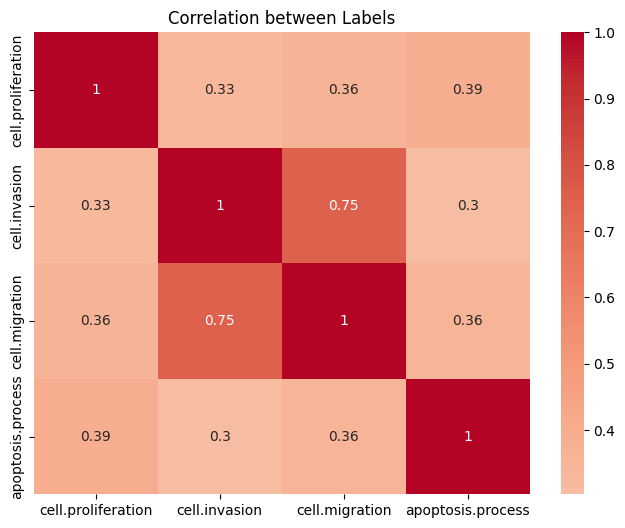

In [7]:

labels_df = lnc_feat_df.iloc[:, 1:5]
print(labels_df.head())
selected_labels = labels_df.columns
corr_matrix = labels_df[selected_labels].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Labels')
plt.show()


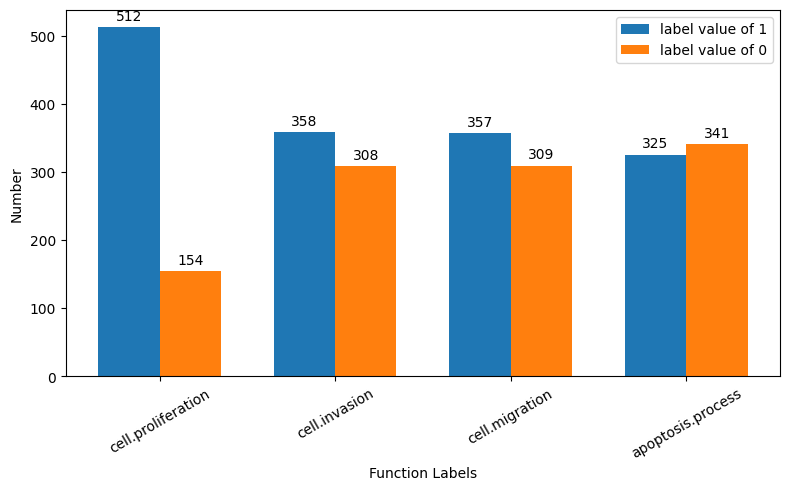

In [8]:
label_df = lnc_feat_df.iloc[:, 1:5]

counts_1 = label_df.apply(lambda x: (x==1).sum())
counts_0 = label_df.apply(lambda x: (x==0).sum())

labels = counts_1.index
x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, counts_1, width, label='label value of 1')
rects2 = ax.bar(x + width/2, counts_0, width, label='label value of 0')

ax.set_xlabel('Function Labels')
ax.set_ylabel('Number')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.tight_layout()
plt.show()

In [9]:
new_order = ['Regulator', 'cell.proliferation'] + [col for col in lnc_feat_df.columns if col not in ['Regulator',
                                                                                                     'cell.proliferation', 
                                                                                                     'cell.invasion',
                                                                                                     'cell.migration',
                                                                                                    'apoptosis.process']]

lnc_feat_df = lnc_feat_df[new_order]
print(lnc_feat_df.head())

cols = lnc_feat_df.columns.tolist()
new_cols = ['lncRNA', 'label'] + [f'feat_{i}' for i in range(1, len(cols)-1)]
lnc_feat_df.columns = new_cols

print(lnc_feat_df.head())

   Regulator  cell.proliferation  length  GC_content    A_freq    T_freq  \
0    A2M-AS1                   1    2930    0.429693  0.282253  0.288055   
1      AATBC                   1    4598    0.614180  0.221618  0.164202   
2     ABALON                   0    1903    0.565423  0.216500  0.218077   
3  ACTA2-AS1                   1    2450    0.483265  0.267347  0.249388   
4   ACTG1P25                   1    2321    0.506247  0.234382  0.259371   

     G_freq    C_freq  dimer_AA  dimer_AC  ...  feature_119  feature_120  \
0  0.200000  0.229693       259       156  ...    -0.075707     0.131054   
1  0.316007  0.298173       237       279  ...    -0.088064     0.085754   
2  0.262218  0.303205       122        88  ...     0.110509    -0.117067   
3  0.266122  0.217143       166       125  ...    -0.016995     0.037305   
4  0.231366  0.274882       127       136  ...     0.023095    -0.093766   

   feature_121  feature_122  feature_123  feature_124  feature_125  \
0     0.030071  

In [10]:
# -------- Meta-path view construction functions --------
def metapath_lnc_mi_lnc(edges_df, lnc_list):
    """
    Construct the lncRNA–miRNA–lncRNA meta-path view.
    Returns edge_index for this view.
    """
    adj = {}
    for _, row in edges_df.iterrows():
        if row['A_type'] == 'lncRNA' and row['B_type'] == 'miRNA':
            adj.setdefault(row['A'], set()).add(row['B'])
    mi2lnc = {}
    for lnc, mis in adj.items():
        for mi in mis:
            mi2lnc.setdefault(mi, set()).add(lnc)
    edge_set = set()
    for lnc_set in mi2lnc.values():
        for u, v in combinations(sorted(lnc_set), 2):
            edge_set.add((u, v))
    node2idx = {nid: i for i, nid in enumerate(lnc_list)}
    edges = list(edge_set)
    if len(edges) > 0:
        edge_index = torch.tensor([
            [node2idx[u] for u, v in edges] + [node2idx[v] for u, v in edges],
            [node2idx[v] for u, v in edges] + [node2idx[u] for u, v in edges]
        ], dtype=torch.long)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    return edge_index

def metapath_lnc_pcg_lnc(edges_df, lnc_list):
    """
    lncRNA–PCG–lncRNA
    """
    pcg2lnc = {}
    for _, row in edges_df.iterrows():
        if row['A_type'] == 'lncRNA' and row['B_type'] == 'PCG':
            pcg2lnc.setdefault(row['B'], set()).add(row['A'])
    edge_set = set()
    for lnc_set in pcg2lnc.values():
        for u, v in combinations(sorted(lnc_set), 2):
            edge_set.add((u, v))
    node2idx = {nid: i for i, nid in enumerate(lnc_list)}
    edges = list(edge_set)
    if len(edges) > 0:
        edge_index = torch.tensor([
            [node2idx[u] for u, v in edges] + [node2idx[v] for u, v in edges],
            [node2idx[v] for u, v in edges] + [node2idx[u] for u, v in edges]
        ], dtype=torch.long)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    return edge_index


def metapath_lnc_pcg_pcg_lnc(edges_df, lnc_list):
    """
    lncRNA–PCG–PCG–lncRNA
    """
    # lncRNA调控哪些PCG
    lnc2pcg = {}
    for _, row in edges_df.iterrows():
        if row['A_type'] == 'lncRNA' and row['B_type'] == 'PCG':
            lnc2pcg.setdefault(row['A'], set()).add(row['B'])
    # PCG–PCG互作（无向）
    pcg_edges = set()
    for _, row in edges_df.iterrows():
        if row['A_type'] == 'PCG' and row['B_type'] == 'PCG':
            pcg_edges.add((row['A'], row['B']))
            pcg_edges.add((row['B'], row['A']))
    # 构建lncRNA–PCG–PCG–lncRNA路径
    edge_set = set()
    for lncA in lnc_list:
        for pcg1 in lnc2pcg.get(lncA, []):
            for pcg2 in set([b for a, b in pcg_edges if a == pcg1]):
                for lncB in [lnc for lnc, pcgs in lnc2pcg.items() if pcg2 in pcgs]:
                    if lncA != lncB:
                        u, v = sorted([lncA, lncB])
                        edge_set.add((u, v))
    node2idx = {nid: i for i, nid in enumerate(lnc_list)}
    edges = list(edge_set)
    if len(edges) > 0:
        edge_index = torch.tensor([
            [node2idx[u] for u, v in edges] + [node2idx[v] for u, v in edges],
            [node2idx[v] for u, v in edges] + [node2idx[u] for u, v in edges]
        ], dtype=torch.long)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    return edge_index

In [11]:
# Build meta-path-based edge indices for lncRNA nodes
lnc_list = lnc_feat_df['lncRNA'].tolist()
edge_index1 = metapath_lnc_mi_lnc(edges_df, lnc_list)
edge_index2 = metapath_lnc_pcg_lnc(edges_df, lnc_list)
edge_index3 = metapath_lnc_pcg_pcg_lnc(edges_df, lnc_list)
edge_index_list = [edge_index1, edge_index2, edge_index3]

print(f"View1 edges (lnc-mi-lnc): {edge_index1.size(1)//2}")
print(f"View2 edges (lnc-pcg-lnc): {edge_index2.size(1)//2}")
print(f"View3 edges (lnc_pcg_pcg_lnc): {edge_index3.size(1)//2}")

View1 edges (lnc-mi-lnc): 594
View2 edges (lnc-pcg-lnc): 10391
View3 edges (lnc_pcg_pcg_lnc): 31654


In [12]:
edge_index1

tensor([[188, 226, 236,  ..., 433, 623, 472],
        [316, 408, 594,  ..., 153, 579, 188]])

In [13]:
# Prepare node features and labels for model input
feat_cols = [c for c in lnc_feat_df.columns if c.startswith('feat_')]
x = torch.tensor(lnc_feat_df[feat_cols].values, dtype=torch.float)
y = torch.tensor(lnc_feat_df['label'].values, dtype=torch.long)

# Train/validation/test split
idx = torch.arange(x.size(0))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)
train_idx, val_idx  = train_test_split(train_idx, test_size=0.25, random_state=42)  # 0.6 train, 0.2 val, 0.2 test

# PyG 2.x metadata definition: required for HANConv
node_types = ['lncRNA']
edge_types = [
    ('lncRNA', 'meta1', 'lncRNA'),  # Meta-path 1
    ('lncRNA', 'meta2', 'lncRNA'),  # Meta-path 2
    ('lncRNA', 'meta3', 'lncRNA'),  # Meta-path 2
]
metadata = (node_types, edge_types)

In [14]:
print(metadata)

(['lncRNA'], [('lncRNA', 'meta1', 'lncRNA'), ('lncRNA', 'meta2', 'lncRNA'), ('lncRNA', 'meta3', 'lncRNA')])


In [15]:

# Define the HAN model (multi-view, lncRNA node classification)
class HANforLncRNA(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, metadata, dropout=0.5):
        super().__init__()
        # HANConv: multi-view GNN with attention over meta-paths
        self.han = HANConv(
            in_channels=in_dim,
            out_channels=hidden_dim,
            metadata=metadata,
            heads=8,
        )
        self.lin = nn.Linear(hidden_dim, out_dim)  # HANConv outputs hidden_dim (not hidden_dim*heads)
        self.dropout = dropout

    def forward(self, x, edge_index_list):
        # PyG HANConv expects dict inputs: {node_type: x}, {edge_type: edge_index}
        x_dict = {'lncRNA': x}
        edge_index_dict = {etype: edge_index_list[i] for i, etype in enumerate(metadata[1])}
        h_dict = self.han(x_dict, edge_index_dict)
        h = h_dict['lncRNA']
        h = F.dropout(h, p=self.dropout, training=self.training)
        return self.lin(h)

# Instantiate model
model = HANforLncRNA(
    in_dim=x.size(1),
    hidden_dim=32,
    out_dim=2,
    metadata=metadata,
    dropout=0.1
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# -------- Training loop with early stopping --------
best_val = 0.0
patience = 50
patience_cnt = 0

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index_list)
    loss = F.cross_entropy(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(x, edge_index_list)
        pred = out.argmax(dim=-1)
        train_acc = (pred[train_idx] == y[train_idx]).float().mean().item()
        val_acc   = (pred[val_idx]   == y[val_idx]).float().mean().item()
        test_acc  = (pred[test_idx]  == y[test_idx]).float().mean().item()
    print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")
    if val_acc > best_val:
        best_val = val_acc
        best_state = model.state_dict()
        patience_cnt = 0
    else:
        patience_cnt += 1
        if patience_cnt >= patience:
            print("Early stopping.")
            break

Epoch 001 | Loss: 37.5757 | Train: 0.6692 | Val: 0.6617 | Test: 0.7164
Epoch 002 | Loss: 15.4621 | Train: 0.6692 | Val: 0.6541 | Test: 0.7164
Epoch 003 | Loss: 14.6477 | Train: 0.6717 | Val: 0.6541 | Test: 0.7164
Epoch 004 | Loss: 11.9867 | Train: 0.6742 | Val: 0.6541 | Test: 0.7164
Epoch 005 | Loss: 10.2206 | Train: 0.6742 | Val: 0.6466 | Test: 0.7164
Epoch 006 | Loss: 11.6709 | Train: 0.6892 | Val: 0.6617 | Test: 0.7164
Epoch 007 | Loss: 10.8087 | Train: 0.6817 | Val: 0.6992 | Test: 0.7164
Epoch 008 | Loss: 9.2361 | Train: 0.6817 | Val: 0.7068 | Test: 0.7388
Epoch 009 | Loss: 8.7496 | Train: 0.6967 | Val: 0.7143 | Test: 0.7313
Epoch 010 | Loss: 10.2021 | Train: 0.6992 | Val: 0.7068 | Test: 0.7388
Epoch 011 | Loss: 8.7451 | Train: 0.6992 | Val: 0.7068 | Test: 0.7463
Epoch 012 | Loss: 7.5436 | Train: 0.6992 | Val: 0.7068 | Test: 0.7388
Epoch 013 | Loss: 8.7183 | Train: 0.6967 | Val: 0.7143 | Test: 0.7313
Epoch 014 | Loss: 7.9820 | Train: 0.6867 | Val: 0.7068 | Test: 0.7388
Epoch 015 | 

In [16]:
# -------- Final evaluation on test set --------
model.load_state_dict(best_state)
model.eval()
with torch.no_grad():
    out = model(x, edge_index_list)
    pred = out.argmax(dim=-1)
    print("\nFinal Test accuracy:", (pred[test_idx] == y[test_idx]).float().mean().item())


Final Test accuracy: 0.753731369972229


In [18]:

model.load_state_dict(best_state)
model.eval()
with torch.no_grad():
    out = model(x, edge_index_list)
    prob = out.softmax(dim=1)[:, 1].cpu().numpy() if out.shape[1] == 2 else None  
    pred = out.argmax(dim=-1).cpu().numpy()
    y_true = y[test_idx].cpu().numpy()
    y_pred = pred[test_idx]
    
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\nFinal Test balanced accuracy: {bal_acc:.4f}")
    print(f"Final Test precision: {pre:.4f}")
    print(f"Final Test recall: {rec:.4f}")
    print(f"Final Test F1-score: {f1:.4f}")
    if prob is not None:
        auc = roc_auc_score(y_true, prob[test_idx])
        print(f"Final Test ROC-AUC: {auc:.4f}")



Final Test balanced accuracy: 0.6753
Final Test precision: 0.8586
Final Test recall: 0.8173
Final Test F1-score: 0.8374
Final Test ROC-AUC: 0.8147
